# Machine Learning Nanodegree

## Capstone Project: Instacart Market Basket Analysis

### Notebook for Exploratory Data Analysis
** Which products will an Instacart consumer purchase again? **

The dataset for this challenge is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

In [0]:
### Import libraries XXXXXXXXXXXXXXXXXXXX
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

%matplotlib inline

**Code for setting up Google Colaboratory**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Load a file by ID and create local file.

downloaded = drive.CreateFile({'id':'1L05r3qtAhmzFfNazo8xfKkKbWRwQhODZ'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('order_products__train.csv') # now you can use export.csv 

downloaded = drive.CreateFile({'id':'14sI0oP8FXxfYd_0OmaAPfqPSrrRyvoIH'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('order_products__prior.csv') # now you can use export.csv 

downloaded = drive.CreateFile({'id':'1dSIrVAQ5delsaDYbjdB7gzsxTCf792kf'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('orders.csv') # now you can use export.csv 

downloaded = drive.CreateFile({'id':'1F4sDO7oTimeDNrI2FcaEkx9WnF7_n1y5'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('products.csv') # now you can use export.csv 

downloaded = drive.CreateFile({'id':'1b122CO2v4on8ixfE-8Cc6g4RHcARiTvn'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('aisles.csv') # now you can use export.csv 

downloaded = drive.CreateFile({'id':'1YNGRUqCG9slq8fPwjwAFb0WwuzBbJVE8'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('departments.csv') # now you can use export.csv 

**Import the Instacart data**

In [0]:
gc.collect()
### Import Instacart Data
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
orders_df = pd.read_csv("orders.csv")
products_df = pd.read_csv("products.csv")
aisles_df = pd.read_csv("aisles.csv")
departments_df = pd.read_csv("departments.csv")

print('Total no. of orders: {}'.format(orders_df.shape[0]))
print('Total no. of products: {}'.format(products_df.shape[0]))
print('Total no. of aisles: {}'.format(aisles_df.shape[0]))
print('Total no. of departments: {}'.format(departments_df.shape[0]))

Total no. of orders: 3421083
Total no. of products: 49688
Total no. of aisles: 134
Total no. of departments: 21


---
<a id='step1'></a>
## Data Exploration

### Orders
orders_df tells about each order made by the a specific user (user_id) and each order is classifed as prior, train or test. 
There are more than 3.4 million orders, wih more than 3.2 million orders classified as 'prior', more than 130,000 as 'train' and 75000 as 'test'


MNSHR

In [0]:
orders_df.groupby("eval_set").order_id.aggregate({'total_orders':'nunique'}).reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,eval_set,total_orders
0,prior,3214874
1,test,75000
2,train,131209


In [0]:
orders_df.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [0]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Looking at the number of unique users that can be counted in the order_df data set, there are more than 200,000 users who made more than 3.2 million orders in the past. We have 131209 users making same number of last order and classified as 'train' in orders_df and 75000 users' orders classified as 'test'

In [0]:
order_cnt = orders_df.groupby("eval_set").user_id.aggregate({'total_user':'nunique'}).reset_index()
print(order_cnt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


  eval_set  total_user
0    prior      206209
1     test       75000
2    train      131209


These data frames (order__products_\_[prior/train]_df specify which products were purchased in each order. order_products_prior_df contains previous order contents for all customers. 

'reordered' indicates that the customer has a previous order that contains the product. (Some orders will have no reordered items). We may predict an explicit 'None' value for orders with no reordered items. 

We have 206209 unique customers based on user_id in total, for 131209 the last purchase is provided and for 75000 we need to predict their next purchase. There are more than 3.4 million orders as mentioned in the data release blog post. For each user, 4 to 100 orders with sequence of products purchased is also provided. 

### Prior Products 
Taking a look at the order_product_prior_df, the describe function reveales that there are more than 32 million prior records consisting of all the products made by about 200,000 users for more than 3.2 million orders. The data set has a 'reordered' field to tell if the user reordered the given product. A value of 1 means that the product was reordered.

In [0]:
order_products_prior_df.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


In [0]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Train Products

As shown below there are about 1.3 million records in the order_products_train_df data set, with product_id to identify the product, order_id to tell, which order was the product a part of and a 'reordered' field to tell if the product was reordered, just as it does in case of Prior Producs data set.

In [0]:
order_products_train_df.describe()

,order_id,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,4.968800e+04,8.000000e+01,1.000000e+00


In [0]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Products, Aisles, Department

  There are 49688 products, part of 134 aisles and 21 departments

In [0]:
products_df.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


In [0]:
print(products_df.head())
products_df.tail()

   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  


,product_id,product_name,aisle_id,department_id
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8
49687,49688,Fresh Foaming Cleanser,73,11


In [0]:
aisles_df.describe()

,aisle_id
count,134.000000
mean,67.500000
std,38.826537
min,1.000000
25%,34.250000
50%,67.500000
75%,100.750000
max,134.000000


In [0]:
print(aisles_df.head())
print(aisles_df.tail())

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation
     aisle_id                       aisle
129       130    hot cereal pancake mixes
130       131                   dry pasta
131       132                      beauty
132       133  muscles joints pain relief
133       134  specialty wines champagnes


In [0]:
departments_df.describe()

,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000


In [0]:
departments_df

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


Since products, aisles and departments data frames could be related amongst themselves using IDs as keys, we can merge them recursively and create a single data frame (pad_df for products, aisles and dept) for simplification as below:

In [0]:
pad_df = pd.merge(left=pd.merge(left=products_df, right=departments_df, how='left'), right=aisles_df, how='left')
print(pad_df.describe())
pad_df.head()

gc.collect()

         product_id      aisle_id  department_id
count  49688.000000  49688.000000   49688.000000
mean   24844.500000     67.769582      11.728687
std    14343.834425     38.316162       5.850410
min        1.000000      1.000000       1.000000
25%    12422.750000     35.000000       7.000000
50%    24844.500000     69.000000      13.000000
75%    37266.250000    100.000000      17.000000
max    49688.000000    134.000000      21.000000


40

<a id='step2'></a>
## Exploratory Vizualizations

### Eval Set Visualization

A simple bar graph to compare the orders classified as prior, train or test

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


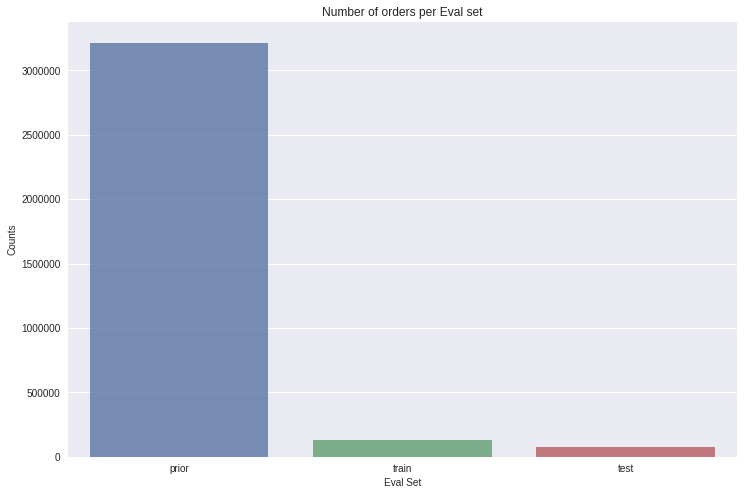

In [0]:
eval_cnt = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(eval_cnt.index, eval_cnt.values, alpha=0.8)
plt.title('Order count per Eval set', fontsize=12)
plt.xlabel('Eval Set', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.show()

### Max orders by users

Looking at the maximum number of orders per user. Each user has made at least 4 orders, with around 24000 users making 4 orders,less than 20000 users making 5 orders and so on. At the end of the chart we see a sharp rise in the number of users making 100 orders. That could be related to some promotion, but is an interesting insight revealed by the graph.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


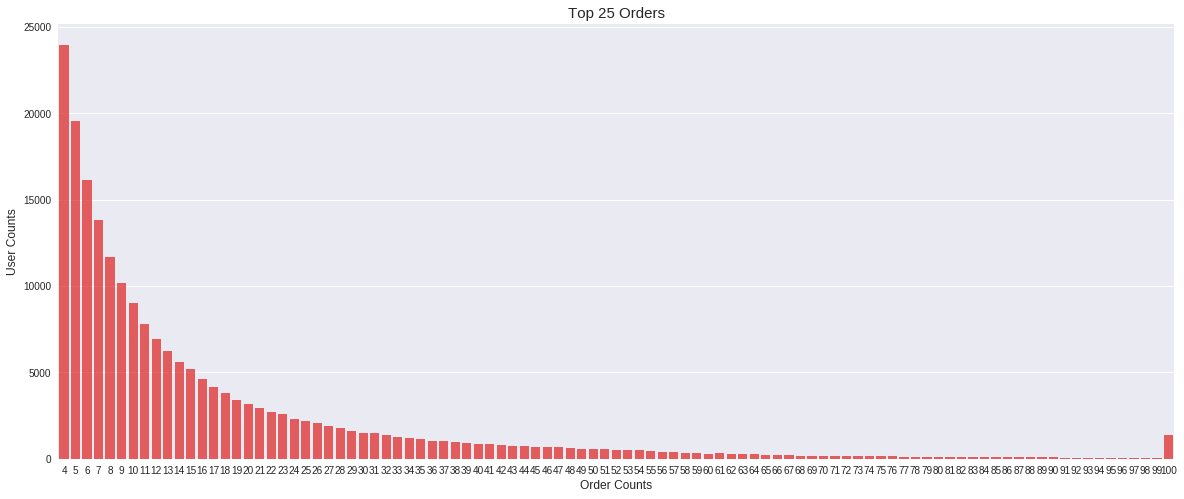

21878

In [0]:
orders_user = orders_df.groupby('user_id')['order_number'].max().reset_index()
orders_user = orders_user.order_number.value_counts()

plt.figure(figsize=(20,8))
sns.barplot(orders_user.index, orders_user.values, color='r', alpha=0.7)
plt.xlabel('Order Counts', fontsize=12)
plt.ylabel('User Counts', fontsize=12)
plt.title('Top 50 Orders', fontsize=15)
plt.xlim(right=50)
plt.show()

gc.collect()

### Orders by Time

In this section I'll explore the orders data set with the timing information provided. information such as order day of the week and time of the day etc.

**Orders by day of week**

0 being Sunday and Monday are amongst the busiest days for Instacart shopping.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


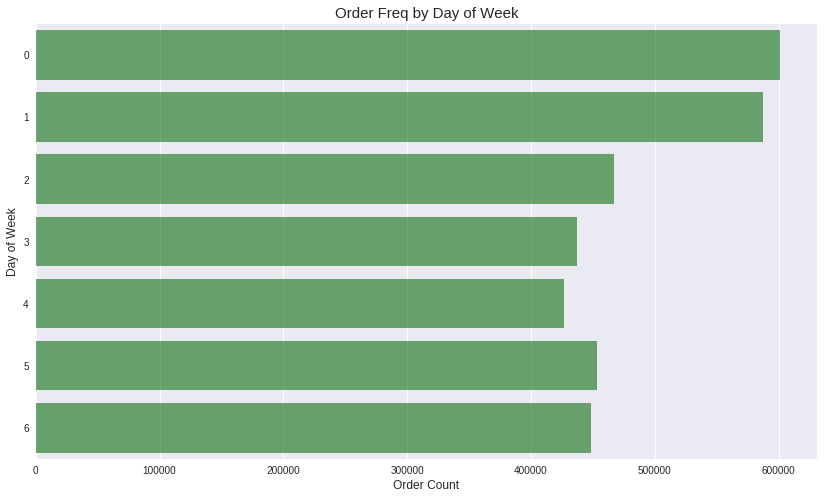

In [0]:
plt.figure(figsize=(14,8))
sns.countplot(y=orders_df.order_dow, color='g', alpha=0.6)
plt.xlabel('Order Counts', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.title('Orders counts by Day of Week', fontsize=15)
plt.show()

**Orders by hour of day**

Orders start picking up later morning and continue through the work day typically between 9 am and 5 pm.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


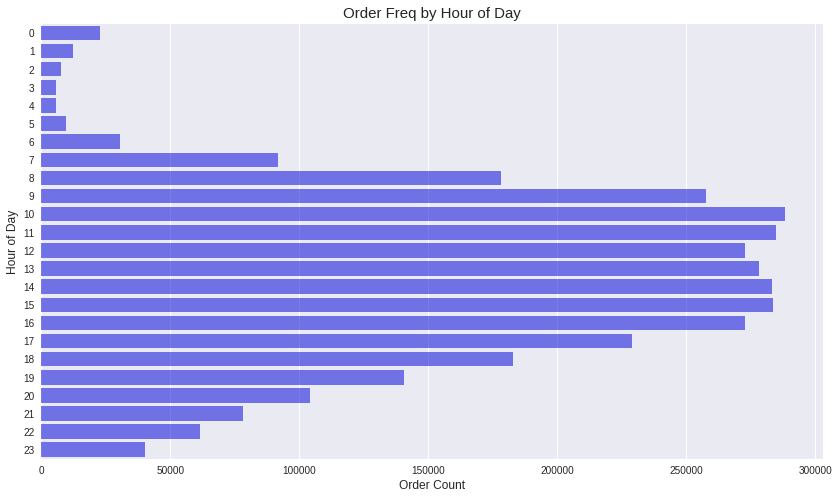

In [0]:
plt.figure(figsize=(14,8))
sns.countplot(y=orders_df.order_hour_of_day, color='b', alpha=0.6)
plt.xlabel('Order Count', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.title('Order Freq by Hour of Day', fontsize=15)
plt.show()

**Orders by hours over the weekends**

Late mornings and early afternoons seem to be most busy periods, pattern not exactly similar but close to all 7 days in the previous chart.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


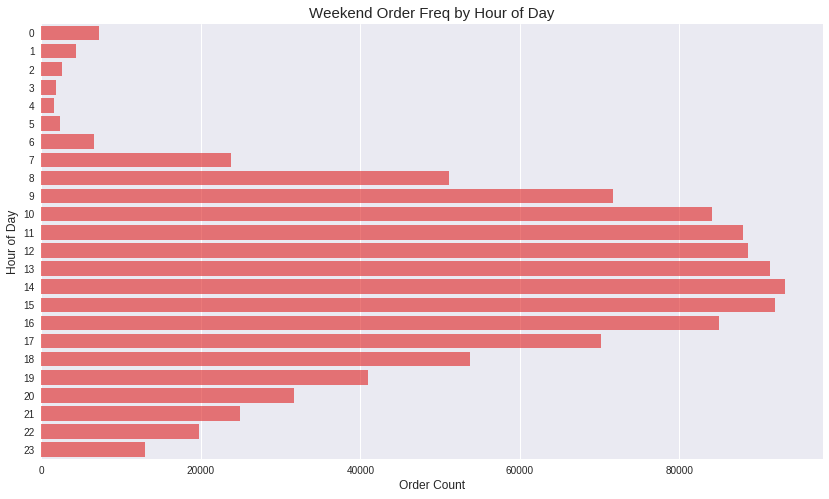

In [0]:
orders_wkend1=orders_df.loc[lambda df: orders_df["order_dow"] == 0,:]
orders_wkend2=orders_df.loc[lambda df: orders_df["order_dow"] == 6,:]
orders_wkend=pd.concat([orders_wkend1, orders_wkend2])
del orders_wkend1
del orders_wkend2
orders_wkend

plt.figure(figsize=(14,8))
sns.countplot(y=orders_wkend.order_hour_of_day, color='r', alpha=0.6)
plt.xlabel('Order Count', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.title('Weekend Order counts by hour of day', fontsize=15)
plt.show()

**Days since past order**

There is a peak at 30 days, probably Instacart has set this as the upper limit for this data set, for days > 30. Other than that 7 is the highest number of days which shows a weekly pattern in ordering frequency. Probably around weekends.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


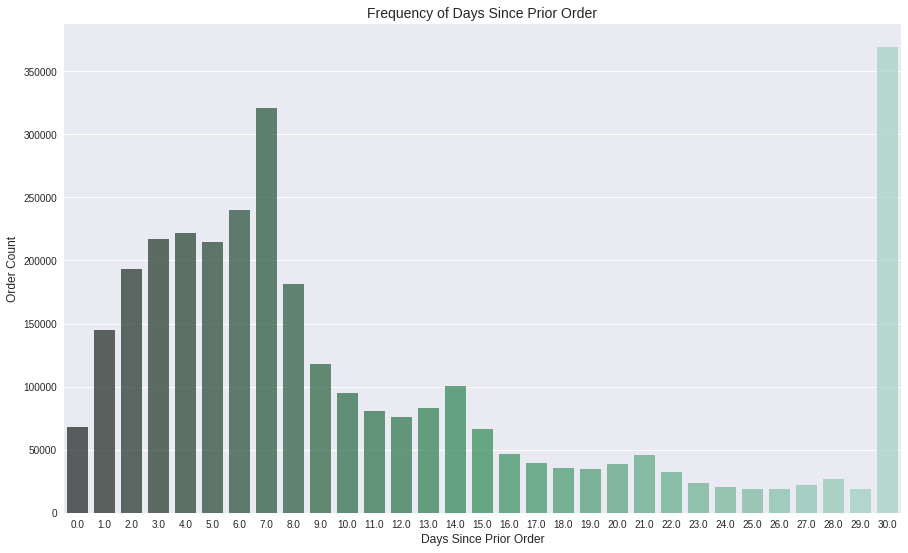

16854

In [0]:

plt.figure(figsize=(15,9))
sns.countplot(orders_df.days_since_prior_order, palette='BuGn_d', alpha=0.7)
plt.title('Days Since Prior Order Frequency', fontsize=15)
plt.ylabel('Order Counts', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.show()

gc.collect()

**Heat map for order counts by day and hour**

The chart shows that Sunday afternoons and Monday mornings are most busy

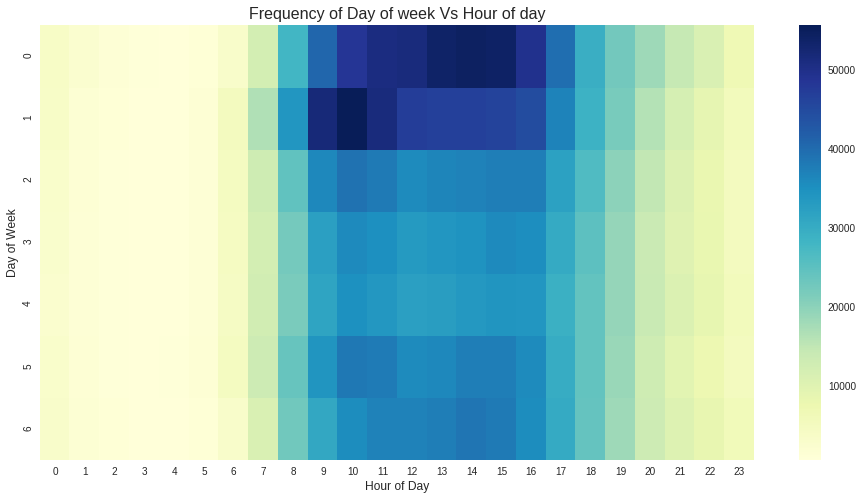

4912

In [0]:
# Orders by day of week and hour of day
plt.figure(figsize=(16,8))
order_cnt = orders_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate('count').reset_index()
order_cnt = order_cnt.pivot( 'order_dow', 'order_hour_of_day', 'order_number')
sns.heatmap(order_cnt, cmap='YlGnBu')

plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.title('Count density - Hour of day vs Day of week', fontsize=16)
plt.show()

gc.collect()

### Visualizations with Grouped Data

In [0]:
pad_df = pd.merge(left=pd.merge(left=products_df, right=departments_df, how='left'), right=aisles_df, how='left')
orders_prior_pad_df = pd.merge(pd.merge(order_products_prior_df, orders_df, on='order_id', how='left'), pad_df, on='product_id')

gc.collect()

91

Lets delete some of the unecessary data frames

In [0]:
del order_products_prior_df
del temp_series
del labels
gc.collect()

5799

In [0]:
orders_train_pad_df = pd.merge(pd.merge(order_products_train_df, orders_df, on='order_id', how='left'), pad_df, on='product_id')

grouped_df = orders_train_pad_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
val_cnt = grouped_df.add_to_cart_order.value_counts()

gc.collect()

35

In [0]:
del order_products_train_df


**Plotting frequency of orders by number of products per order**

The peak frequency is about 6 products per order with around 1-10 products per order with high frequency and a sharp decline subsequently

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


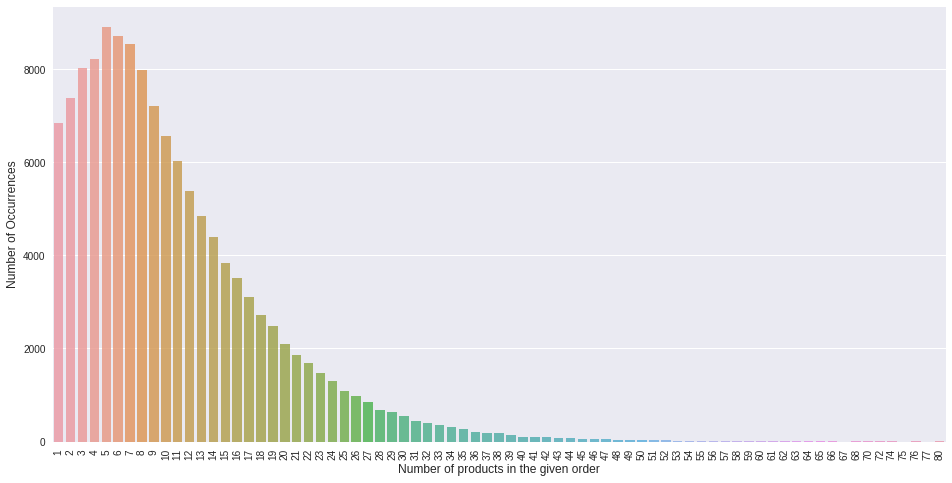

In [0]:
plt.figure(figsize=(16,8))
sns.barplot(val_cnt.index, val_cnt.values, alpha=0.8)
plt.ylabel('Frequency of orders', fontsize=12)
plt.xlabel('Number of products per order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#cleanup
gc.collect()
del grouped_df

**Showing top 20 popular products by name**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


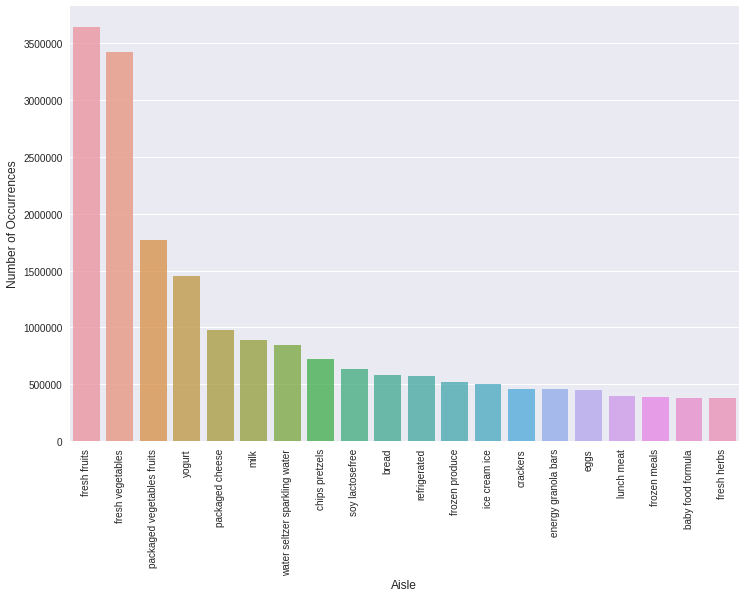

5454

In [0]:
val_cnt_aisle = orders_prior_pad_df['product_name'].value_counts().reset_index().head(20)
val_cnt_aisle.columns = ['product_name', 'frequency_count']

val_cnt_aisle = orders_prior_pad_df['aisle'].value_counts().head(20)

plt.figure(figsize=(12,8))
sns.barplot(val_cnt_aisle.index, val_cnt_aisle.values, alpha=0.8)
plt.ylabel('Order Count', fontsize=12)
plt.xlabel('Aisles', fontsize=12)
plt.title('Top 20 Aisles with Most Purchased Products', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

gc.collect()

**This chart shows the top 10 departments by order counts**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


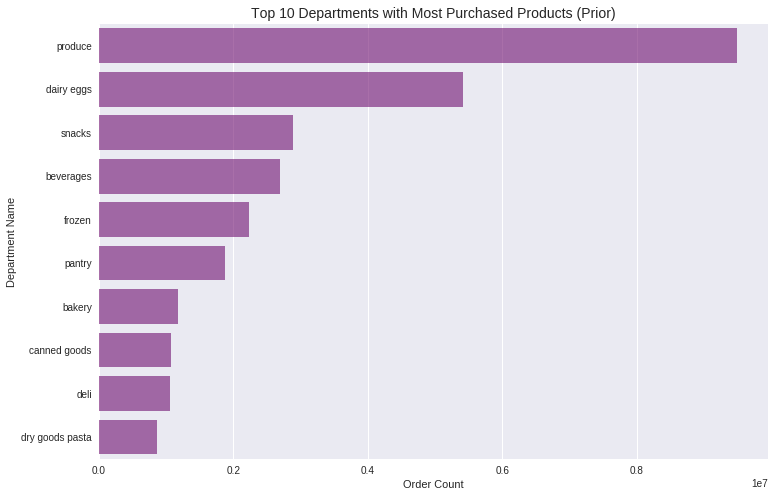

3473

In [0]:
del val_cnt

# Departments with most ordered products
prod_cnts = orders_prior_pad_df.department.value_counts().head(10)

plt.figure(figsize=(12,8))
sns.barplot(prod_cnts.values, prod_cnts.index, color='purple', alpha=0.6)
plt.xlabel('Order Count', fontsize=11)
plt.ylabel('Department Name', fontsize=11)
plt.title('Top 10 Departments with most ordered products', fontsize=14)
plt.show()

gc.collect()

In [0]:
del prod_cnts

---
<a id='step3'></a>
## Data Preprocessing

Starting with sorting the values based on user_id and order_number for the user.

In [0]:
orders_df.sort_values(by=['user_id', 'order_number'], inplace=True)
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [0]:
#Replace NaN with mean
orders_df.days_since_prior_order.fillna(orders_df.days_since_prior_order.mean(), inplace=True)
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,11.114836
1,2398795,1,prior,2,3,7,15.000000
2,473747,1,prior,3,3,12,21.000000
3,2254736,1,prior,4,4,7,29.000000
4,431534,1,prior,5,4,15,28.000000


During exploration I discovered that there is one Department and one Aisle labeled "Missing"
Let's explore that more..

In [0]:
print(departments_df[departments_df.department == 'missing'])
missing_prod_df = products_df[products_df.department_id == 21].reset_index()
print (len(missing_prod_df), "products items are associated with department='missing'")

#checking for any missing labled aisles
print(aisles_df[aisles_df.aisle == 'missing'])

missing_prod_df.head()

    department_id department
20             21    missing
1258 products items are associated with department='missing'
    aisle_id    aisle
99       100  missing


,index,product_id,product_name,aisle_id,department_id
0,37,38,Ultra Antibacterial Dish Liquid,100,21
1,71,72,Organic Honeycrisp Apples,100,21
2,109,110,Uncured Turkey Bologna,100,21
3,296,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21
4,416,417,Classics Baby Binks Easter Chocolate Bunny,100,21


Since departments and aisles are categorical variables, we chose to keep the missing values for the given products and save them in a separate data structure missing_prod_df.

**This chart shows the pie chart distribution for different departments by products ordered**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


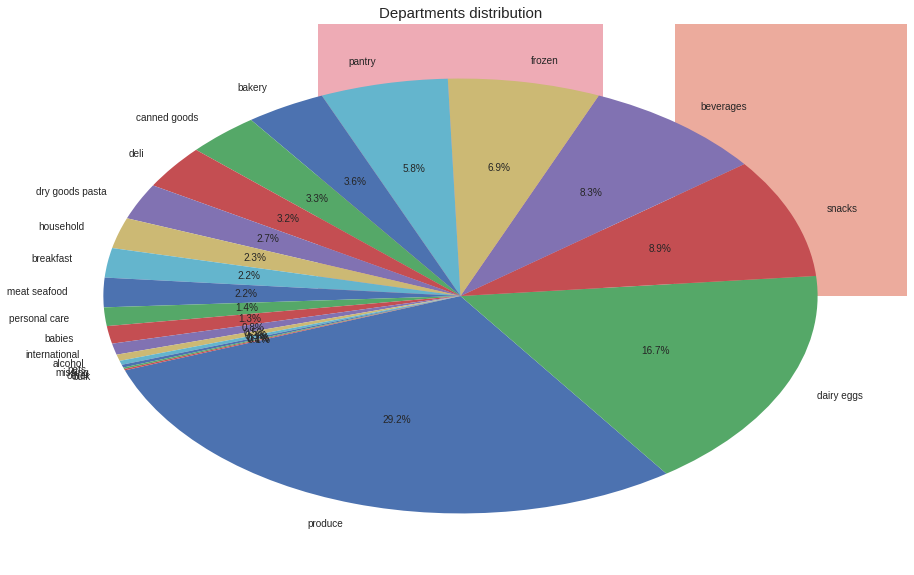

In [0]:
plt.figure(figsize=(16,10))
temp_series = orders_prior_pad_df['department'].value_counts()
labels = (np.array(temp_series.index))
sns.barplot(temp_series.index, temp_series.values, alpha=0.8)

sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()
#print (orders_prior_pad_df.describe())

**Clenup**

In [0]:
del missing_prod_df
del orders_df
del temp_series
del labels
del sizes
del pad_df
gc.collect()

7451